In [13]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Quora Duplicate qns
Can you identify question pairs that have the same intent?

About Dataset
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

In [14]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install --upgrade nltk

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Dense, LSTM, Embedding, Lambda, InputLayer
from tensorflow.keras import Sequential, Model, Input

from collections import Counter, defaultdict
import contractions
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Import Data

In [18]:
quora = pd.read_csv("/kaggle/input/quora-duplicate-qns/quora.csv")
# quora = pd.read_csv("quora.csv")
quora.head()

,Unnamed: 0,index,id,qid1,qid2,question1,question2,is_duplicate
0,0,8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
1,1,368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
2,2,70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
3,3,226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
4,4,73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1


In [19]:
quora.shape

(100000, 8)

In [20]:
quora.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    100000 non-null  int64 
 1   index         100000 non-null  int64 
 2   id            100000 non-null  int64 
 3   qid1          100000 non-null  int64 
 4   qid2          100000 non-null  int64 
 5   question1     100000 non-null  object
 6   question2     100000 non-null  object
 7   is_duplicate  100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [21]:
for col in quora.select_dtypes("int64").columns:
    print(col, quora[col].nunique())

Unnamed: 0 100000
index 100000
id 100000
qid1 87035
qid2 87347
is_duplicate 2


In [22]:
print(quora.qid1.value_counts()[:10])
print()
print(quora.qid2.value_counts()[:10])

8461     18
21712    16
38362    15
1749     14
4951     13
159      13
8353     12
9006     12
35043    12
6799     12
Name: qid1, dtype: int64

2559     29
4044     26
30782    23
17978    17
28764    17
2561     17
9262     14
30647    14
691      14
20542    13
Name: qid2, dtype: int64


In [23]:
quora.is_duplicate.value_counts(1)

0    0.62879
1    0.37121
Name: is_duplicate, dtype: float64

# Data Preprocessing
## Split data

In [24]:
y = quora.is_duplicate
X = quora[["qid1", "question1", "qid2","question2"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 80,stratify = y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size = 0.5, random_state = 11,stratify = y_test)
print(y_train.shape, y_val.shape, y_test.shape)

(80000,) (10000,) (10000,)


In [25]:
X_train.head()

,qid1,question1,qid2,question2
82222,110534,How can I copy and paste text in Instagram?,270043,How do I copy and paste on my Android phone?
37773,272049,What is the difference between a general denti...,272050,What are the differences between pediatric den...
53888,47907,How do I calculate IQ?,56293,How do you know your IQ?
80815,512918,What would happen if Quora credits were sudden...,133403,What would happen if Quora credits were sudden...
22035,26940,What is the meaning of preceding year?,26941,"What is the meaning of the word ""precede""?"


In [26]:
X_val.drop(columns = ["qid1", "qid2"], inplace = True)
X_test.drop(columns = ["qid1", "qid2"], inplace = True)

In [27]:
X_test.head()

,question1,question2
85389,Is it true that you can see who’s viewed your ...,Is there a way to see who viewed my Instagram ...
50950,Is sex important in love?,How important is sex in a relationship?
13382,What should I say when someone is expressing c...,How can you tell when someone is faking confid...
90276,What can middle aged people do to achieve clar...,Is penicillin necessary to remove an eye infec...
54261,Would i still be able to make a website if we ...,Will all website hosting providers be banned w...


## Duplicates in training set

As we see, the questions (qids) are not unique. For those duplicated question pairs, a question could be paired with several other questions, and they are all having similar meanings. We could group questions with similar meanings in a union, while questions with different meanings should be included in different unions.

In [28]:
def dfs(m: dict, visited: set, node: int) -> list:
    res = [node]
    for other in m[node]:
        if other in visited:
            continue
        
        visited.add(other)
        res += dfs(m, visited, other)
        
    return res
    
def find_qid_relation(X_train, y_train):
    m = defaultdict(list)
    
    q1 = X_train.qid1.values
    q2 = X_train.qid2.values
    y_tmp = y_train.values
    
    for i in range(len(q1)):
        if y_tmp[i]:
            m[q1[i]].append(q2[i])
            m[q2[i]].append(q1[i])
      
    num_union = 0
    visited = set()  # store visited qids
    qid_union = {}  # key: qid, value: the union this qid belongs to, duplicates belong to the same union
    union_qid = []  # index: union, value: qids belongs to the same union
    
    for k in m.keys():
        if k in visited:
            continue
            
        visited.add(k)
        nodes = dfs(m, visited, k)
        for node in nodes:
            qid_union[node] = num_union
  
        union_qid.append(nodes)
        num_union += 1
  
    return union_qid, qid_union 

In [29]:
# the mapping between unions to qids, and qids to unions among duplicates
union_qid, qid_union = find_qid_relation(X_train, y_train)

In [30]:
print(r"the number of unique qids corresponding to 'is_duplicate = 1':", len(qid_union))
print("the number of unions:", len(union_qid))

the number of unique qids corresponding to 'is_duplicate = 1': 44023
the number of unions: 17802


## Pre-process text

In [31]:
def fix_contractions(text):    # expand contraction
    return contractions.fix(text)

def remove_punctuation(text):   # remove punctuations
    return re.sub(r"[^\w\d\s]+", '', text)

def tokenize(text):   # tokenize
    return word_tokenize(text)

stemmer = PorterStemmer()
def lemmatizer(tokens):    # stemming
    return " ".join([stemmer.stem(word, to_lowercase = True) for word in tokens ])

In [32]:
sample = "What's going on at 1234 Carrier Dr? He can't concentrate on his assignment!!"
print("original:", sample)
t2 = fix_contractions(sample)
print("\nremove contraction:",t2)
t3 = remove_punctuation(t2)
print("\nremove punctuation:",t3)
t4 = tokenize(t3)
print("\ntokenize:", t4)
t5 = lemmatizer(t4)
print("\nlemmatization:", t5)

original: What's going on at 1234 Carrier Dr? He can't concentrate on his assignment!!

remove contraction: What is going on at 1234 Carrier Dr? He cannot concentrate on his assignment!!

remove punctuation: What is going on at 1234 Carrier Dr He cannot concentrate on his assignment

tokenize: ['What', 'is', 'going', 'on', 'at', '1234', 'Carrier', 'Dr', 'He', 'can', 'not', 'concentrate', 'on', 'his', 'assignment']

lemmatization: what is go on at 1234 carrier dr he can not concentr on hi assign


In [33]:
def process_text(text):
    text = fix_contractions(text)
    text = remove_punctuation(text)
    text = tokenize(text)
    text = lemmatizer(text)
    return text

In [34]:
def process_questions(X):
    X.question1 = X.question1.apply(process_text)
    X.question2 = X.question2.apply(process_text)
    return X

In [35]:
X_train.head()

,qid1,question1,qid2,question2
82222,110534,How can I copy and paste text in Instagram?,270043,How do I copy and paste on my Android phone?
37773,272049,What is the difference between a general denti...,272050,What are the differences between pediatric den...
53888,47907,How do I calculate IQ?,56293,How do you know your IQ?
80815,512918,What would happen if Quora credits were sudden...,133403,What would happen if Quora credits were sudden...
22035,26940,What is the meaning of preceding year?,26941,"What is the meaning of the word ""precede""?"


In [36]:
X_train = process_questions(X_train)
X_val = process_questions(X_val)
X_test = process_questions(X_test)

In [37]:
X_train.head()

,qid1,question1,qid2,question2
82222,110534,how can i copi and past text in instagram,270043,how do i copi and past on my android phone
37773,272049,what is the differ between a gener dentist and...,272050,what are the differ between pediatr dentist an...
53888,47907,how do i calcul iq,56293,how do you know your iq
80815,512918,what would happen if quora credit were suddenl...,133403,what would happen if quora credit were suddenl...
22035,26940,what is the mean of preced year,26941,what is the mean of the word preced


## Vocabulary

In [38]:
q1_words = [word for question in X_train.question1.values for word in question.split(" ")]
q2_words = [word for question in X_train.question2.values for word in question.split(" ")]
unique_words = Counter(q1_words + q2_words) 
print("the number of unique words in training set:", len(unique_words))

the number of unique words in training set: 36081


In [39]:
print("first most frequent word:", unique_words.most_common(1)[-1])
print("6000th most frequent word:", unique_words.most_common(6000)[-1])

first most frequent word: ('the', 74685)
6000th most frequent word: ('align', 12)


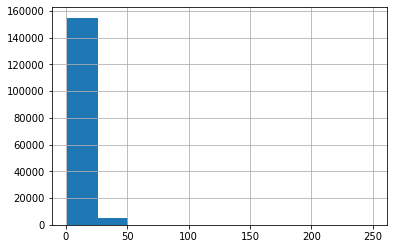

In [40]:
q1_sequence_len = [len(question.split(" ")) for question in X_train.question1.values ]
q2_sequence_len = [len(question.split(" ")) for question in X_train.question2.values ]
pd.Series(q1_sequence_len + q2_sequence_len).hist();

In [41]:
print("95% of the sequences with the length <=", np.quantile(q1_sequence_len + q2_sequence_len, 0.95))

95% of the sequences with the length <= 23.0


It could be a decent value to set maximum sequence length as 30.

In [42]:
VOCAB_SIZE = 6000
MAX_SEQUENCE_LEN = 30

# A preprocessing layer which maps text features to integer sequences
text_vector = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=None,
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LEN,
    pad_to_max_tokens=False)

text_vector.adapt(pd.concat([X_train.question1, X_train.question2], axis = 0))
text_vector.vocabulary_size()

2022-06-23 22:56:25.597708: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-06-23 22:56:25.597754: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-23 22:56:25.597790: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2af6f35465f6): /proc/driver/nvidia/version does not exist
2022-06-23 22:56:25.598321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the

6000

In [43]:
X_train.question2.values[0]

'how do i copi and past on my android phone'

In [44]:
text_vector(X_train.question2.values[0])

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([   6,   10,    5, 1441,   13,  733,   21,   19,  213,  121,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])>

In [45]:
def convert_text_to_sequence(X):
    return text_vector(X.question1.values), text_vector(X.question2.values)
    
X_train_q1, X_train_q2 = convert_text_to_sequence(X_train)
X_val_q1, X_val_q2 = convert_text_to_sequence(X_val)
X_test_q1, X_test_q2 = convert_text_to_sequence(X_test)

In [46]:
X_train_q1[:3]

<tf.Tensor: shape=(3, 30), dtype=int64, numpy=
array([[   6,   14,    5, 1441,   13,  733,  577,    9,  198,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   3,    4,    2,   48,   54,    7,  289, 2696,   13,    7, 4132,
        2696,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   6,   10,    5,  544,  752,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]])>

## Data generator

There're multiple questions occurring in the training set repeatedly. Let's map each unique qid to its question tensor, and store in a dictionary.

In [47]:
def qid_question(X, X_q1, X_q2):  # map qid to question tensor
    m = {id: t for id, t in zip(X.qid1.values, X_q1)}
    m.update({id: t for id, t in zip(X.qid2.values, X_q2)})
    return m

In [48]:
qid_tensor = qid_question(X_train, X_train_q1, X_train_q2)  # mapping between unique qids to the corresponding tensors in training set

In [50]:
print("the number of unique questions (qids) in training set:", len(qid_tensor))

the number of unique questions (qids) in training set: 136303


In [ ]:
# def train_generator_v1(X, y, batch_size = 64):
#     duplicates = X.loc[y == 1, ["qid1", "qid2"]]
#     inputs = []
    
#     all_qids = list(set(np.concatenate((X.qid1.values, X.qid2.values))))  # all unique qids
    
#     while True:
#         for i, row in duplicates.iterrows():
#             qid1, qid2 = row["qid1"], row["qid2"]
#             anc = qid_tensor[qid1]
#             inputs.append([anc, qid_tensor[qid2]])

#             neg_id = np.random.choice(all_qids)
#             while neg_id == qid1 or neg_id == qid2:
#                 neg_id = np.random.choice(all_qids)
#             inputs.append([anc, qid_tensor[neg_id]])

#             if len(inputs) == batch_size:
#                 yield [np.array(inputs)], [1, 0] * (batch_size >> 1)

#                 inputs = [] 

In [ ]:
# def train_generator_v2(X, y, batch_size = 64):
#     duplicates = X.loc[y == 1, ["qid1", "qid2"]]
#     anchor = []
#     other = []
#     all_qids = list(set(np.concatenate((X.qid1.values, X.qid2.values))))  # all unique qids in X
    
#     while True:
#         for i, row in duplicates.iterrows():
#             qid1, qid2 = row["qid1"], row["qid2"]
#             anc = qid_tensor[qid1]
#             anchor += [anc, anc]

#             neg_id = np.random.choice(all_qids)
#             while neg_id == qid1 or neg_id == qid2:
#                 neg_id = np.random.choice(all_qids)
#             other += [qid_tensor[qid2], qid_tensor[neg_id]]

#             if len(anchor) == batch_size:
#                 yield [np.array(anchor), np.array(other)], np.array([1, 0] * (batch_size >> 1))

#                 anchor = [] 
#                 other = []

In [51]:
all_qids = list(qid_tensor.keys())  # all unique qids in X_train

def train_generator_v3(batch_size = 64):
    anchor = []
    other = []
    unions = [*range(len(union_qid))]
    
    while True:
        for anchor_id, union in qid_union.items():
            anc = qid_tensor[anchor_id]
            anchor += [anc, anc]

            pos_id = np.random.choice(union_qid[union])  # select a positive example from the same union
            while pos_id == anchor_id:
                pos_id = np.random.choice(union_qid[union])
                
            neg_id = np.random.choice(all_qids)  # select a negative example not from the same union
            if neg_id in qid_union:
                while qid_union[neg_id] == union:
                    neg_id = np.random.choice(all_qids)
                    
                    if neg_id not in qid_union:
                        break
            
            other += [qid_tensor[pos_id], qid_tensor[neg_id]]
#             print("triplet:",anchor_id, pos_id, neg_id)
            if len(anchor) == batch_size:
                yield [np.array(anchor), np.array(other)], np.array([1, 0] * (batch_size >> 1))

                anchor = [] 
                other = []

In [52]:
tmp = train_generator_v3(batch_size = 2)
for i in range(2):
    print(next(tmp))
    print("\n\n")

([array([[  6,  10,   5, 544, 752,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  6,  10,   5, 544, 752,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]]), array([[  6,  10,  16,  71,  36, 752,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  6,  10,   5, 602,  19, 752,  15, 184,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]])], array([1, 0]))



([array([[  6,  10,  16,  71,  36, 752,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  6,  10,  16,  71,  36, 752,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   

# Model Building

In [53]:
def history_plot(history):
    plt.figure(figsize = (15,5));
    
    ax1 = plt.subplot(121);
    ax1.plot(history["loss"], color = 'r', marker = 'o', label = "Train Loss");
    ax1.plot(history["val_loss"], color = 'b',marker = 'o', label = "Val Loss");
    plt.legend(loc="best");
    
    ax2 = plt.subplot(122);    
    ax2.plot(history["accuracy"], color = 'r', marker = 'o', label = "Train Accuracy");
    ax2.plot(history["val_accuracy"], color = 'b', marker = 'o', label = "Val Accuracy");    
    plt.legend(loc="best");

In [54]:
alpha = 0.6

def triplet_loss(v):
    v1, v2 = v
    v1 = v1.numpy()
    v2 = v2.numpy()
    score = np.dot(v1, v2.T)    
    batch_size = score.shape[0]    
    print("\nv1:\n", v1, "\nv2:\n", v2, "\nscore:\n", score)
    
    pos = np.diag(score)
    print("\npositive:\n",pos)
    
    negatives = score - np.diag(pos)
    print("\nnegatives:\n",negatives)
    
    mean_negative = np.sum(negatives, axis = 1) / max((batch_size - 1),1)
    print("\nmean_negative:\n", mean_negative)
    
    closest_negative = np.max(negatives - 2 * np.eye(batch_size), axis = 1)
    print("\nclosest_neagtive:\n", closest_negative)    

    trip_loss1 = np.maximum(-pos + mean_negative + alpha, 0)
    trip_loss2 = np.maximum(-pos + closest_negative + alpha, 0)
    loss = trip_loss1 + trip_loss2
    print("\ntrip_loss1:\n", trip_loss1,"\nloss:\n", loss)
    
    return tf.convert_to_tensor(loss.reshape(1, -1))

In [66]:
WORD_EMBEDDING_DIM = 30
LEARNING_RATE = 0.0001

def normalized_by_column(X):
    return X / tf.norm(X, axis = 1, keepdims=True)  # normalized by column

def base_net(X):
    X = Embedding(input_dim = VOCAB_SIZE, output_dim = WORD_EMBEDDING_DIM, input_length = MAX_SEQUENCE_LEN)(X)
    X = LSTM(16, dropout = 0.3)(X)
    output = Lambda(function = normalized_by_column)(X)
#     print("\noutput:\n",output)
    return output


def cosine_similarity(v):
    v1, v2 = v
    cos = tf.reduce_sum(v1 * v2, axis = -1,keepdims= True)
    return tf.maximum(cos, 0)   # cosine similarity between 0 ~ 1

def Siamese():
    Input1 = Input(shape=(MAX_SEQUENCE_LEN, ))   # used to instantiate a Keras tensor.
    Input2 = Input(shape=(MAX_SEQUENCE_LEN, ))
    
    v1 = base_net(Input1)  # convert tensor to numpy array
    v2 = base_net(Input2)

    distance_layer = Lambda(function = cosine_similarity, name = "similarity")([v1, v2])
    model = Model(inputs = [Input1, Input2], outputs = distance_layer)    
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), metrics=["accuracy"])
    
    model.summary()
    return model

In [67]:
model = Siamese()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 30, 30)       180000      ['input_9[0][0]']                
                                                                                                  
 embedding_9 (Embedding)        (None, 30, 30)       180000      ['input_10[0][0]']               
                                                                                            

In [ ]:
# BATCH_SIZE = 64
# train_set_size = 25000

# history = model.fit(x = train_generator_v3(batch_size = BATCH_SIZE), 
#                     validation_data = ([X_val_q1[:1000], X_val_q2[:1000]], y_val[:1000]), 
#                     steps_per_epoch = train_set_size // BATCH_SIZE,
#                     epochs = 20)

In [68]:
BATCH_SIZE = 64
train_set_size = len(y_train) # 25000

history = model.fit(x = [X_train_q1[:train_set_size], X_train_q2[:train_set_size]], 
                            y = y_train[:train_set_size],  
                            batch_size = BATCH_SIZE, 
                            validation_data = ([X_val_q1, X_val_q2], y_val), 
                            validation_batch_size = BATCH_SIZE,
                            epochs = 20)

Epoch 1/20
1250/1250 [==============================] - 28s 19ms/step - loss: 0.6966 - accuracy: 0.6252 - val_loss: 0.6419 - val_accuracy: 0.6315
Epoch 2/20
1250/1250 [==============================] - 23s 18ms/step - loss: 0.6344 - accuracy: 0.6542 - val_loss: 0.5929 - val_accuracy: 0.7163
Epoch 3/20
1250/1250 [==============================] - 23s 18ms/step - loss: 0.5949 - accuracy: 0.6983 - val_loss: 0.5870 - val_accuracy: 0.7158
Epoch 4/20
1250/1250 [==============================] - 23s 18ms/step - loss: 0.5681 - accuracy: 0.7263 - val_loss: 0.5714 - val_accuracy: 0.7288
Epoch 5/20
1250/1250 [==============================] - 23s 18ms/step - loss: 0.5513 - accuracy: 0.7357 - val_loss: 0.5581 - val_accuracy: 0.7322
Epoch 6/20
1250/1250 [==============================] - 22s 18ms/step - loss: 0.5419 - accuracy: 0.7389 - val_loss: 0.5603 - val_accuracy: 0.7243
Epoch 7/20
1250/1250 [==============================] - 22s 18ms/step - loss: 0.5312 - accuracy: 0.7415 - val_loss: 0.5491 -

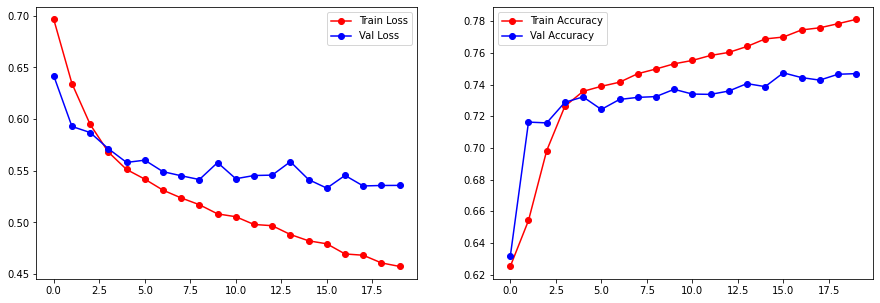

In [69]:
history_plot(history.history)

In [70]:
print("Train:")
model.evaluate([X_train_q1, X_train_q2], y_train)
print("Validation:")
model.evaluate([X_val_q1, X_val_q2], y_val)
print("Test:")
model.evaluate([X_test_q1, X_test_q2], y_test)

Train:
2500/2500 [==============================] - 15s 6ms/step - loss: 0.4412 - accuracy: 0.7908
Validation:
313/313 [==============================] - 2s 7ms/step - loss: 0.5358 - accuracy: 0.7469
Test:
313/313 [==============================] - 2s 6ms/step - loss: 0.5404 - accuracy: 0.7375


[0.5404465198516846, 0.737500011920929]